In [3]:
import pickle

import genjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import rerun as rr
import trimesh
from genjax import Pytree

import b3d
import b3d.bayes3d as bayes3d
import b3d.chisight.dense.dense_model
from b3d import Mesh, Pose
from b3d.chisight.dense.likelihoods.laplace_likelihood import likelihood_func

with open('09-22-2024-17:10:49.pkl', 'rb') as f:
    data = pickle.load(f)

b3d.rr_init("aidan_gear_data")


In [4]:
frame = 0
# downsample image to support larger-scale parallel rendering
downsample_factor = 2 #1
camera_mat = data[frame]['camera_image']['camera_matrix'][0]
rgb_frame = data[frame]['camera_image']['rgbPixels']/255.0
depth_frame = data[frame]['camera_image']['depthPixels']

width = rgb_frame.shape[1]
height = rgb_frame.shape[0]
fx = camera_mat[0,0]
fy = camera_mat[1,1]
cx = camera_mat[0,2]
cy = camera_mat[1,2]
near = 0.001
far = 16.0
scaling_factor = 1.0/downsample_factor

rgb_frame = jnp.clip(jax.image.resize(rgb_frame, (rgb_frame.shape[0]//downsample_factor, rgb_frame.shape[1]//downsample_factor, rgb_frame.shape[2]), 'linear'), 0, 1)
depth_frame = jax.image.resize(depth_frame, (depth_frame.shape[0]//downsample_factor, depth_frame.shape[1]//downsample_factor), 'linear')
rgbd_frame = jnp.concatenate([rgb_frame, depth_frame[...,None]], axis = -1)

renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    cx * scaling_factor,
    cy * scaling_factor,
    0.01,
    20.0,
)

intrinsics = (rgb_frame.shape[1], rgb_frame.shape[0], camera_mat[0,0], camera_mat[1,1], 
              camera_mat[0,2], camera_mat[1,2], 0.001, 16.0)

point_cloud = b3d.camera.unproject_depth(depth_frame, intrinsics).reshape(-1,3)

b3d.rr_log_cloud(point_cloud, 'frame/cloud')
b3d.rr_log_rgb(rgb_frame, 'frame/rgb')

In [5]:
def rotation_from_axis_angle(axis, angle):
    """Creates a rotation matrix from an axis and angle.

    Args:
        axis (jnp.ndarray): The axis vector. Shape (3,)
        angle (float): The angle in radians.
    Returns:
        jnp.ndarray: The rotation matrix. Shape (3, 3)
    """
    sina = jnp.sin(angle)
    cosa = jnp.cos(angle)
    direction = axis / jnp.linalg.norm(axis)
    # rotation matrix around unit vector
    R = jnp.diag(jnp.array([cosa, cosa, cosa]))
    R = R + jnp.outer(direction, direction) * (1.0 - cosa)
    direction = direction * sina
    R = R + jnp.array(
        [
            [0.0, -direction[2], direction[1]],
            [direction[2], 0.0, -direction[0]],
            [-direction[1], direction[0], 0.0],
        ]
    )
    return R

In [6]:
# fixing the result of RANSAC fit
# fit_plane_pose = b3d.utils.fit_plane(point_cloud, 1e-3, 100, 100)
fit_plane_pose = Pose(jnp.array([0.00638516, 0.26058754, 0.632996  ]), jnp.array([-0.6930068 ,  0.69431657, -0.13396354, -0.14042774]))


In [7]:
# flip_transformation
flip_transformation = Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([1,0,0]), jnp.pi))
fit_plane_pose_adjusted = fit_plane_pose @ Pose.from_translation(jnp.array([0.6,-0.3,0]))


rr.log("frame/plane", rr.Transform3D(translation=fit_plane_pose.pos, mat3x3=fit_plane_pose.as_matrix()[:3,:3]))
rr.log("frame/plane2", rr.Transform3D(translation=fit_plane_pose_adjusted.pos, mat3x3=fit_plane_pose_adjusted.as_matrix()[:3,:3]))

In [8]:
mesh_path = 'GEABP1.0-20-10-B-10_Gear_20teeth.stl'
mesh = trimesh.load(mesh_path)
# convert from mm to meter scale
mesh.vertices = mesh.vertices/1000
mesh.vertices -= jnp.mean(mesh.vertices, axis=0)
# flip gear
mesh.vertices = flip_transformation.apply(mesh.vertices)
# move to table surface
mesh.vertices[:,2] += jnp.min(mesh.vertices, axis=0)[2]

pix_color = jnp.array([18/256.0, 104/256.0, 151/256.0])
colors = jnp.repeat(pix_color[None,...], mesh.vertices.shape[0], axis=0)


In [9]:
# fit_plane_pose = b3d.utils.fit_plane(point_cloud, 1e-3, 100, 100)
# fit_plane_pose = Pose(jnp.array([0.00950025, 0.24012217, 0.2285265 ]), jnp.array([-0.2693774 ,  0.28788412,  0.6456935 ,  0.65394074]))
obj_pose = fit_plane_pose_adjusted @ Pose.from_translation(jnp.array([-0.1,-0.1,0]))


In [10]:
model, viz_trace, info_from_trace = (
        b3d.chisight.dense.dense_model.make_dense_multiobject_model(
            renderer, likelihood_func
        )
    )
importance_jit = jax.jit(model.importance)

likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
}

In [11]:
choicemap = genjax.ChoiceMap.d(
        {
            "rgbd": rgbd_frame,
            "camera_pose": Pose.identity(),
            "object_pose_0": obj_pose,
            "object_0": 0,
            "depth_noise_variance": 0.005,
            "color_noise_variance": 0.05,
            "outlier_probability": 0.1,
        }
    )

gear_mesh = Mesh(mesh.vertices,mesh.faces,colors)

trace, _ = importance_jit(
        jax.random.PRNGKey(0),
        choicemap,
        (
            {
                "num_objects": Pytree.const(1),
                "meshes": [gear_mesh],
                "likelihood_args": likelihood_args,
            },
        )
    )

trace = b3d.update_choices(
    trace,
    Pytree.const(["rgbd"]),
    rgbd_frame,
)

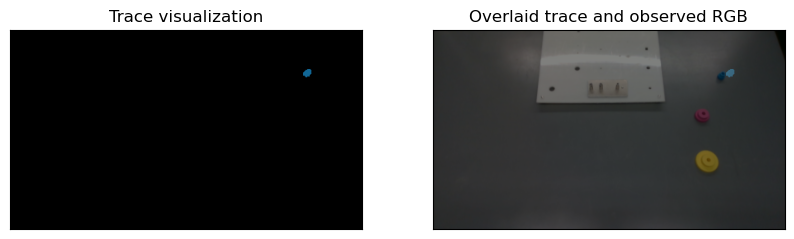

In [12]:
# viz_trace(trace, 1)

def show_trace_and_observed(trace):
    rgbd = renderer.render_rgbd(trace.get_choices()['object_pose_0'].apply(mesh.vertices),
        mesh.faces,
        colors)

    fig, axs = plt.subplots(1,2, figsize=(10, 8))
    axs[0].imshow(rgbd[...,:3])
    axs[0].set_title('Trace visualization')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow((trace.get_choices()['rgbd'][...,:3] + rgbd[...,:3])/2)
    axs[1].set_title('Overlaid trace and observed RGB')
    axs[1].set_xticks([])
    axs[1].set_yticks([])

show_trace_and_observed(trace)

In [13]:
# Gridding on translation only.
# 0.05 order of magnitude grid moves
x_num_points, y_num_points = 25, 25
x_grid, y_grid = jnp.linspace(-0.1, 0.1, x_num_points), jnp.linspace(-0.1, 0.1, y_num_points)
translation_deltas = jax.vmap(lambda p: Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    y_grid,
                    x_grid,
                    jnp.linspace(0, 0, 1),
                ),
                axis=-1,
            ).reshape(-1, 3)
        )

In [14]:
def _enumerate_and_get_scores(trace, addressses, all_deltas):
    addr = addressses.unwrap()[0]
    current_pose = trace.get_choices()[addr]
    scores_list = []
    for i in range(len(all_deltas)):
        test_poses = current_pose @ all_deltas[i]
        scores = b3d.enumerate_choices_get_scores(
            trace, addressses, test_poses
        )
        scores_list.append(scores)
    return jnp.array(scores_list)


enumerate_and_get_scores = jax.jit(
    _enumerate_and_get_scores, static_argnames=["addressses"]
)

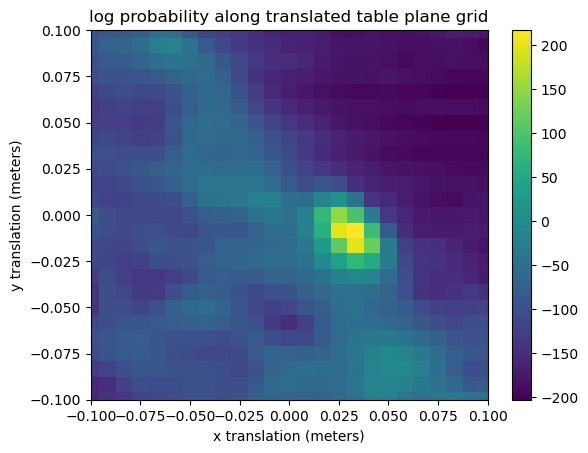

In [15]:
def make_xy_grid_plot(trace, translation_deltas):
    score_grid = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [translation_deltas])
    score_plot_data = score_grid[0].reshape(y_num_points,x_num_points)

    fig, ax = plt.subplots()
    y, x = jnp.meshgrid(y_grid, x_grid)
    c = ax.pcolormesh(x, y, score_plot_data, vmin=jnp.min(score_plot_data), vmax=jnp.max(score_plot_data))
    ax.set_title('log probability along translated table plane grid')
    ax.set_xlabel('x translation (meters)')
    ax.set_ylabel('y translation (meters)')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    plt.show()

make_xy_grid_plot(trace, translation_deltas)

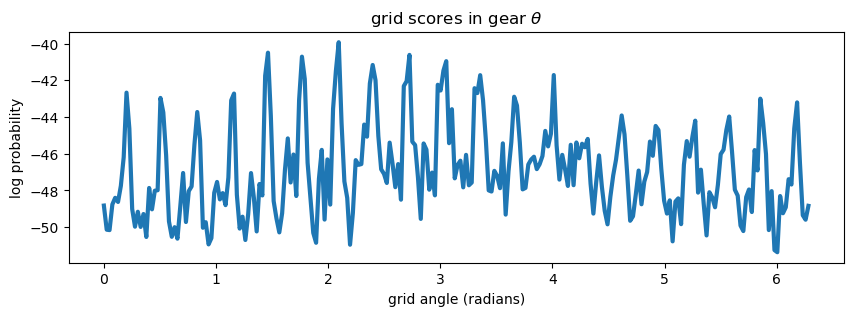

In [16]:
def make_theta_grid_plot(trace, num_rotations = 250):
    rotation_poses = jax.vmap(lambda theta: Pose.from_pos_matrix(jnp.zeros(3), rotation_from_axis_angle(jnp.array([0,0,1]), theta)), 0)(jnp.linspace(0, 2*jnp.pi,num_rotations))
    rotation_score_grid = enumerate_and_get_scores(trace, Pytree.const(("object_pose_0",)), [rotation_poses])
    plt.figure(figsize=(10,3))
    plt.plot(jnp.linspace(0, 2*jnp.pi, 250), rotation_score_grid[0], linewidth=3)
    plt.xlabel('grid angle (radians)')
    plt.ylabel('log probability')
    plt.title(r'grid scores in gear $\theta$')
    plt.show()

make_theta_grid_plot(trace)

In [17]:
key = jax.random.PRNGKey(0)
trace, key = bayes3d.enumerate_and_select_best_move(
    trace, Pytree.const(("object_pose_0",)), key, [translation_deltas]
)

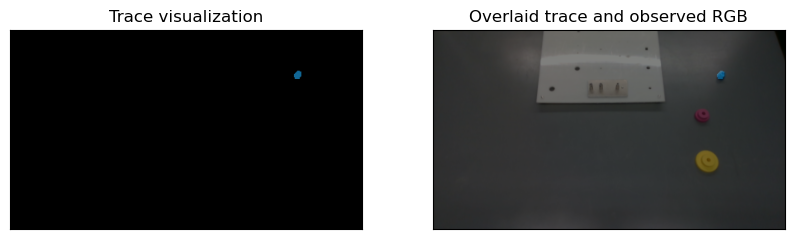

In [18]:
show_trace_and_observed(trace)

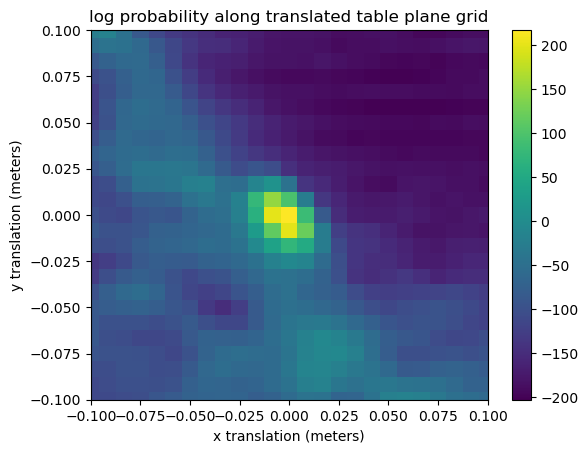

In [19]:
make_xy_grid_plot(trace, translation_deltas)

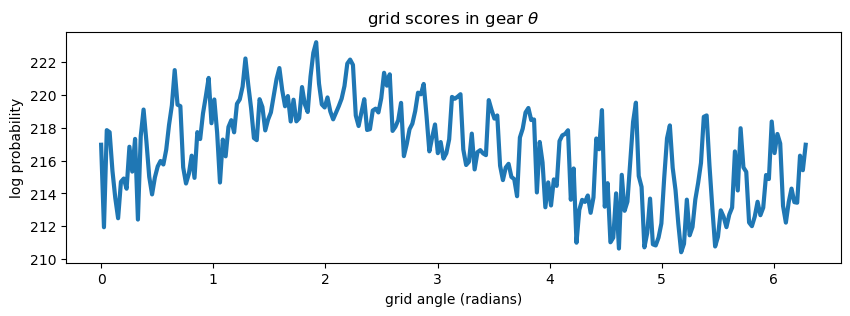

In [20]:
make_theta_grid_plot(trace)